In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 
from datetime import date

from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

%matplotlib inline

import random 
random.seed(42)

In [2]:
csv_path_1 = "training_dataset.csv"
csv_path_2 = "score.csv"

# 0. First, let's understand our data...

In [3]:
df = pd.read_csv(csv_path_1) # load the pandas dataframe
df_score = pd.read_csv(csv_path_2)
initial_cols_to_drop = ["Unnamed: 0","Unnamed: 0.1", "period", "test", "recent_date", "date"] 
for col_name in initial_cols_to_drop: # drops columns that aren't supposed to be in dataset
    try:
        df = df.drop(columns=[col_name])
        df_score = df_score.drop(columns=[col_name])
    except:
        continue
#df = df.rename(columns={"Unnamed: 0.1": "TODO_FIND_COLUMN_NAME_2"})
display(df.head())

,dt,weekday,year,id_driver,id_carrier_number,dim_carrier_type,dim_carrier_company_name,home_base_city,home_base_state,carrier_trucks,...,most_recent_load_date,load_day,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,total_loads
0,2019-12-16,Monday,2019,21350,U0109015,Owner Operator,CA&F TRUCKING,Maywood,CA,"[""poweronly""]",...,2021-02-17,2019-12-16,2,0,438,438,0,45,45,483
1,2021-01-15,Friday,2021,36437,C0097727,Fleet,New opportunities inc,Los Angeles,CA,"[""poweronly"", ""boxtruck""]",...,2021-02-03,2021-01-15,1,2,72,74,0,1,1,75
2,2019-12-26,Thursday,2019,19323,U0107081,Owner Operator,RAS,Compton,CA,"[""poweronly""]",...,2020-09-25,2019-12-26,1,0,180,180,0,2,2,182
3,2021-02-10,Wednesday,2021,34809,C0094651,Fleet,NFS asset Drayage,Lynwood,CA,"[""poweronly"", ""dryvan""]",...,2021-02-17,2021-02-10,3,0,0,0,0,0,0,62
4,2017-07-24,Monday,2017,4728,U0094376,Owner Operator,joes transportation,Norco,CA,"[""dryvan""]",...,2017-10-11,2017-07-24,2,57,0,57,314,0,314,371


In [4]:
df.describe()

,year,id_driver,num_trucks,days_signup_to_approval,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,total_loads
count,83414.000000,83414.000000,83344.000000,71124.000000,83414.000000,83414.000000,83414.000000,83414.000000,83414.000000,83414.000000,83414.000000,83414.000000
mean,2018.960930,18222.414954,22.582921,298.752489,2.076270,29.477762,71.579675,101.057436,148.258422,13.073021,161.331443,266.502661
std,1.359343,11667.704926,48.829719,390.345107,2.672163,88.171940,194.532776,214.502147,415.978060,42.241592,413.792137,448.806175
min,2015.000000,20.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2018.000000,7890.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,37.000000
50%,2019.000000,16299.000000,4.000000,61.000000,1.000000,2.000000,0.000000,13.000000,15.000000,0.000000,37.000000,110.000000
75%,2020.000000,28974.000000,14.000000,497.000000,2.000000,23.000000,18.000000,94.000000,112.000000,1.000000,135.000000,325.000000
max,2021.000000,38125.000000,195.000000,1653.000000,129.000000,902.000000,1324.000000,1348.000000,4266.000000,371.000000,4266.000000,4266.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83414 entries, 0 to 83413
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   dt                        83414 non-null  object 
 1   weekday                   83414 non-null  object 
 2   year                      83414 non-null  int64  
 3   id_driver                 83414 non-null  int64  
 4   id_carrier_number         83414 non-null  object 
 5   dim_carrier_type          83414 non-null  object 
 6   dim_carrier_company_name  83365 non-null  object 
 7   home_base_city            83369 non-null  object 
 8   home_base_state           83369 non-null  object 
 9   carrier_trucks            83414 non-null  object 
 10  num_trucks                83344 non-null  float64
 11  interested_in_drayage     83414 non-null  object 
 12  port_qualified            83414 non-null  object 
 13  signup_source             83414 non-null  object 
 14  ts_sig

# 1. Generate Labels

In [6]:
# converts date from csv to a python datetime object making it easier to work with
def convert_dates(df):
    dates_columns = ['most_recent_load_date', 'first_load_date', 'load_day', 'dt']
    for col_name in dates_columns:
        try:
            df[col_name] = pd.to_datetime(df[col_name], format='%Y-%m-%d')
        except:
            continue

convert_dates(df)
convert_dates(df_score)

In [7]:
df['most_recent_load_date'].head()

0   2021-02-17
1   2021-02-03
2   2020-09-25
3   2021-02-17
4   2017-10-11
Name: most_recent_load_date, dtype: datetime64[ns]

In [8]:
total_loads75 = df.total_loads.quantile(0.75) # finds 75th percentile of loads
most_recent_load_date75 = df.most_recent_load_date.quantile(0.75) # finds 75th percentile of most recent load date

print(total_loads75)
print(most_recent_load_date75)


# Manual Check
# sorted_dts = sorted(list(df.most_recent_load_date))
# quartile_estimate_index = int(len(sorted_dts)*0.75)
# print("SORTED INDEX", sorted_dts[quartile_estimate_index])

325.0
2021-02-14 00:00:00


In [9]:
# new_labels = {"label": {}}
num_days_worked_dict = {}

for index, row in df.iterrows(): # changes the labels in the label columns
    # checks if the load and most recent load date are in the 75th percentile
    if row["total_loads"] >= total_loads75 and row["most_recent_load_date"] >= most_recent_load_date75:
        df.at[index, "label"] = 1
    else:
        df.at[index, "label"] = 0

<AxesSubplot:xlabel='dt,dt'>

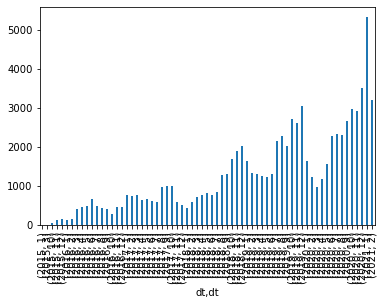

In [10]:
df["dt"].groupby([df["dt"].dt.year, df["dt"].dt.month]).count().plot(kind="bar")

In [11]:
groups = df.groupby("id_driver")

In [12]:
# NO: dt, weekday, year, id_carrier_number, dim_preferred_lanes, load_day, loads
new_arr = []
for key, group in groups:
    group.sort_values(by="load_day", ascending=False, inplace=True)
    temp_arr = []
    temp_arr.append(key)
    
    if group["dim_carrier_type"].nunique() == 2:
        temp_arr.append("Both")
    elif group["dim_carrier_type"].nunique() == 0:
        temp_arr.append(None)
    else:
        temp_arr.append((group["dim_carrier_type"].iloc[0]))
    
    
    idxmax_cols = ["dim_carrier_company_name", "home_base_city", "home_base_state", 
                   "carrier_trucks", "signup_source", "ts_signup", "ts_first_approved",
                  "days_signup_to_approval"]
    
    for col in idxmax_cols:
        try:
            temp_arr.append(group[col].value_counts().dropna(how="any").idxmax())
        except:
            temp_arr.append(None)
    
    try:
        temp_arr.append(group["num_trucks"].dropna(how="any").mean())
    except:
        temp_arr.append(None)
        
    iloc_cols = ["interested_in_drayage", "port_qualified", "driver_with_twic", 
                 "first_load_date", "most_recent_load_date", "marketplace_loads_otr", 
                 "marketplace_loads_atlas", "marketplace_loads", "brokerage_loads_otr",
                 "brokerage_loads_atlas", "brokerage_loads", "total_loads"]
    for col in iloc_cols:
        try:
            temp_arr.append(group[col].dropna(how="any").iloc[0])
        except:
            temp_arr.append(None)
            
    temp_arr.append(group["label"].value_counts().dropna(how="any").idxmax())
            
    temp_arr.append(group.shape[0])
    
    new_arr.append(np.array(temp_arr))

In [13]:
column_names = ["id_driver", "dim_carrier_type", "dim_carrier_company_name", "home_base_city", "home_base_state", 
                "carrier_trucks", "signup_source", "ts_signup", "ts_first_approved",
                "days_signup_to_approval", "num_trucks", "interested_in_drayage", 
                "port_qualified", "driver_with_twic", 
                "first_load_date", "most_recent_load_date", "marketplace_loads_otr", 
                "marketplace_loads_atlas", "marketplace_loads", "brokerage_loads_otr",
                "brokerage_loads_atlas", "brokerage_loads", "total_loads", "num_trips_made", "label"]

df = pd.DataFrame(np.array(new_arr), columns=column_names)

In [14]:
convert = ["id_driver", "days_signup_to_approval", "marketplace_loads_otr", 
               "marketplace_loads_atlas", "marketplace_loads", "brokerage_loads_otr",
               "brokerage_loads_atlas", "brokerage_loads", "total_loads", "num_trips_made", "label",
               "num_trucks", "dim_carrier_type", "dim_carrier_company_name", "home_base_city", "home_base_state",
               "interested_in_drayage", "port_qualified", "signup_source", "driver_with_twic"]
for col in convert:
    df[col] = df[col].convert_dtypes()

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5291 entries, 0 to 5290
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id_driver                 5291 non-null   Int64         
 1   dim_carrier_type          5291 non-null   string        
 2   dim_carrier_company_name  5284 non-null   string        
 3   home_base_city            5279 non-null   string        
 4   home_base_state           5279 non-null   string        
 5   carrier_trucks            5291 non-null   object        
 6   signup_source             5291 non-null   string        
 7   ts_signup                 5291 non-null   object        
 8   ts_first_approved         3962 non-null   object        
 9   days_signup_to_approval   3962 non-null   Int64         
 10  num_trucks                5249 non-null   float64       
 11  interested_in_drayage     5291 non-null   string        
 12  port_qualified      

In [16]:
df["label"].describe()

count    5291.000000
mean       15.765262
std        36.862613
min         1.000000
25%         1.000000
50%         3.000000
75%        12.000000
max       624.000000
Name: label, dtype: float64

In [17]:
groups = df_score.groupby("id_driver")

In [18]:
# NO: dt, weekday, year, id_carrier_number, dim_preferred_lanes, load_day, loads
new_arr = []
for key, group in groups:
    group.sort_values(by="load_day", ascending=False, inplace=True)
    temp_arr = []
    temp_arr.append(key)
    
    if group["dim_carrier_type"].nunique() == 2:
        temp_arr.append("Both")
    elif group["dim_carrier_type"].nunique() == 0:
        temp_arr.append(None)
    else:
        temp_arr.append((group["dim_carrier_type"].iloc[0]))
    
    
    idxmax_cols = ["dim_carrier_company_name", "home_base_city", "home_base_state", 
                   "carrier_trucks", "signup_source", "ts_signup", "ts_first_approved",
                  "days_signup_to_approval"]
    
    for col in idxmax_cols:
        try:
            temp_arr.append(group[col].value_counts().dropna(how="any").idxmax())
        except:
            temp_arr.append(None)
    
    try:
        temp_arr.append(group["num_trucks"].dropna(how="any").mean())
    except:
        temp_arr.append(None)
        
    iloc_cols = ["interested_in_drayage", "port_qualified", "driver_with_twic", 
                 "first_load_date", "load_day", "marketplace_loads_otr", 
                 "marketplace_loads_atlas", "marketplace_loads", "brokerage_loads_otr",
                 "brokerage_loads_atlas", "brokerage_loads"]
    for col in iloc_cols:
        try:
            temp_arr.append(group[col].dropna(how="any").iloc[0])
        except:
            temp_arr.append(None)
            
    temp_arr.append(group.shape[0])
    
    new_arr.append(np.array(temp_arr))

In [19]:
column_names = ["id_driver", "dim_carrier_type", "dim_carrier_company_name", "home_base_city", "home_base_state", 
                "carrier_trucks", "signup_source", "ts_signup", "ts_first_approved",
                "days_signup_to_approval", "num_trucks", "interested_in_drayage", 
                "port_qualified", "driver_with_twic", 
                "first_load_date", "most_recent_load_date", "marketplace_loads_otr", 
                "marketplace_loads_atlas", "marketplace_loads", "brokerage_loads_otr",
                "brokerage_loads_atlas", "brokerage_loads", "num_trips_made"]

df_score = pd.DataFrame(np.array(new_arr), columns=column_names)

In [20]:
convert = ["id_driver", "days_signup_to_approval", "marketplace_loads_otr", 
               "marketplace_loads_atlas", "marketplace_loads", "brokerage_loads_otr",
               "brokerage_loads_atlas", "brokerage_loads", "num_trips_made",
               "num_trucks", "dim_carrier_type", "dim_carrier_company_name", "home_base_city", "home_base_state",
               "interested_in_drayage", "port_qualified", "signup_source", "driver_with_twic"]
for col in convert:
    df_score[col] = df_score[col].convert_dtypes()

In [21]:
df_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668 entries, 0 to 667
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id_driver                 668 non-null    Int64         
 1   dim_carrier_type          668 non-null    string        
 2   dim_carrier_company_name  668 non-null    string        
 3   home_base_city            668 non-null    string        
 4   home_base_state           668 non-null    string        
 5   carrier_trucks            668 non-null    object        
 6   signup_source             668 non-null    string        
 7   ts_signup                 668 non-null    object        
 8   ts_first_approved         572 non-null    object        
 9   days_signup_to_approval   572 non-null    Int64         
 10  num_trucks                668 non-null    float64       
 11  interested_in_drayage     668 non-null    string        
 12  port_qualified        

# 3. Basic Statistics

In [22]:
corr_matrix = df.corr()
for col_name in (list(df.columns.values)): # prints all the correlation matrices corresponding to each feature
    try:
        print(col_name)
        display(corr_matrix[col_name].sort_values(ascending=False))
        print('---------------------------------------------------------------------')
    except:
        print("{} is not of type integer".format(col_name))
        print('---------------------------------------------------------------------')

id_driver


id_driver                  1.000000
num_trucks                 0.169567
brokerage_loads_atlas      0.145307
marketplace_loads_atlas    0.138116
marketplace_loads          0.123344
num_trips_made             0.075683
total_loads                0.052722
label                      0.018007
marketplace_loads_otr     -0.012441
brokerage_loads           -0.037352
brokerage_loads_otr       -0.063795
days_signup_to_approval   -0.734778
Name: id_driver, dtype: float64

---------------------------------------------------------------------
dim_carrier_type
dim_carrier_type is not of type integer
---------------------------------------------------------------------
dim_carrier_company_name
dim_carrier_company_name is not of type integer
---------------------------------------------------------------------
home_base_city
home_base_city is not of type integer
---------------------------------------------------------------------
home_base_state
home_base_state is not of type integer
---------------------------------------------------------------------
carrier_trucks
carrier_trucks is not of type integer
---------------------------------------------------------------------
signup_source
signup_source is not of type integer
---------------------------------------------------------------------
ts_signup
ts_signup is not of type integer
---------------------------------------------------------------------
ts_first_approved
ts_first_approved is not of type inte

days_signup_to_approval    1.000000
brokerage_loads_otr        0.048116
brokerage_loads            0.027929
label                      0.010462
marketplace_loads_otr      0.007436
total_loads               -0.043765
num_trucks                -0.053498
num_trips_made            -0.064084
marketplace_loads         -0.089268
brokerage_loads_atlas     -0.092088
marketplace_loads_atlas   -0.099058
id_driver                 -0.734778
Name: days_signup_to_approval, dtype: float64

---------------------------------------------------------------------
num_trucks


num_trucks                 1.000000
id_driver                  0.169567
label                      0.059784
total_loads                0.017664
brokerage_loads_otr        0.001285
brokerage_loads           -0.006155
num_trips_made            -0.035292
brokerage_loads_atlas     -0.042167
marketplace_loads_atlas   -0.050920
days_signup_to_approval   -0.053498
marketplace_loads_otr     -0.058752
marketplace_loads         -0.065660
Name: num_trucks, dtype: float64

---------------------------------------------------------------------
interested_in_drayage
interested_in_drayage is not of type integer
---------------------------------------------------------------------
port_qualified
port_qualified is not of type integer
---------------------------------------------------------------------
driver_with_twic
driver_with_twic is not of type integer
---------------------------------------------------------------------
first_load_date
first_load_date is not of type integer
---------------------------------------------------------------------
most_recent_load_date
most_recent_load_date is not of type integer
---------------------------------------------------------------------
marketplace_loads_otr


marketplace_loads_otr      1.000000
label                      0.511867
marketplace_loads          0.395290
total_loads                0.268972
num_trips_made             0.163324
marketplace_loads_atlas    0.083147
brokerage_loads_otr        0.080873
brokerage_loads            0.080687
days_signup_to_approval    0.007436
brokerage_loads_atlas      0.005160
id_driver                 -0.012441
num_trucks                -0.058752
Name: marketplace_loads_otr, dtype: float64

---------------------------------------------------------------------
marketplace_loads_atlas


marketplace_loads_atlas    1.000000
marketplace_loads          0.948243
num_trips_made             0.577596
total_loads                0.541759
label                      0.445315
brokerage_loads_atlas      0.410271
id_driver                  0.138116
marketplace_loads_otr      0.083147
brokerage_loads            0.059796
brokerage_loads_otr       -0.012599
num_trucks                -0.050920
days_signup_to_approval   -0.099058
Name: marketplace_loads_atlas, dtype: float64

---------------------------------------------------------------------
marketplace_loads


marketplace_loads          1.000000
marketplace_loads_atlas    0.948243
total_loads                0.585073
num_trips_made             0.584442
label                      0.573574
marketplace_loads_otr      0.395290
brokerage_loads_atlas      0.379811
id_driver                  0.123344
brokerage_loads            0.080827
brokerage_loads_otr        0.014158
num_trucks                -0.065660
days_signup_to_approval   -0.089268
Name: marketplace_loads, dtype: float64

---------------------------------------------------------------------
brokerage_loads_otr


brokerage_loads_otr        1.000000
brokerage_loads            0.984385
total_loads                0.803391
label                      0.572785
num_trips_made             0.239032
marketplace_loads_otr      0.080873
days_signup_to_approval    0.048116
marketplace_loads          0.014158
num_trucks                 0.001285
brokerage_loads_atlas     -0.011804
marketplace_loads_atlas   -0.012599
id_driver                 -0.063795
Name: brokerage_loads_otr, dtype: float64

---------------------------------------------------------------------
brokerage_loads_atlas


brokerage_loads_atlas      1.000000
marketplace_loads_atlas    0.410271
marketplace_loads          0.379811
total_loads                0.329874
num_trips_made             0.327819
label                      0.257713
brokerage_loads            0.164395
id_driver                  0.145307
marketplace_loads_otr      0.005160
brokerage_loads_otr       -0.011804
num_trucks                -0.042167
days_signup_to_approval   -0.092088
Name: brokerage_loads_atlas, dtype: float64

---------------------------------------------------------------------
brokerage_loads


brokerage_loads            1.000000
brokerage_loads_otr        0.984385
total_loads                0.850586
label                      0.610399
num_trips_made             0.293505
brokerage_loads_atlas      0.164395
marketplace_loads          0.080827
marketplace_loads_otr      0.080687
marketplace_loads_atlas    0.059796
days_signup_to_approval    0.027929
num_trucks                -0.006155
id_driver                 -0.037352
Name: brokerage_loads, dtype: float64

---------------------------------------------------------------------
total_loads


total_loads                1.000000
brokerage_loads            0.850586
brokerage_loads_otr        0.803391
label                      0.802860
marketplace_loads          0.585073
num_trips_made             0.541811
marketplace_loads_atlas    0.541759
brokerage_loads_atlas      0.329874
marketplace_loads_otr      0.268972
id_driver                  0.052722
num_trucks                 0.017664
days_signup_to_approval   -0.043765
Name: total_loads, dtype: float64

---------------------------------------------------------------------
num_trips_made


num_trips_made             1.000000
marketplace_loads          0.584442
marketplace_loads_atlas    0.577596
total_loads                0.541811
label                      0.481593
brokerage_loads_atlas      0.327819
brokerage_loads            0.293505
brokerage_loads_otr        0.239032
marketplace_loads_otr      0.163324
id_driver                  0.075683
num_trucks                -0.035292
days_signup_to_approval   -0.064084
Name: num_trips_made, dtype: float64

---------------------------------------------------------------------
label


label                      1.000000
total_loads                0.802860
brokerage_loads            0.610399
marketplace_loads          0.573574
brokerage_loads_otr        0.572785
marketplace_loads_otr      0.511867
num_trips_made             0.481593
marketplace_loads_atlas    0.445315
brokerage_loads_atlas      0.257713
num_trucks                 0.059784
id_driver                  0.018007
days_signup_to_approval    0.010462
Name: label, dtype: float64

---------------------------------------------------------------------


 Also year and TODO_FIND_COLUMN_NAME_2 and year are highly correlated and have a similar impact on label, so we could drop one? 

Is there really a need for brokerage_loads when it is so highly correlated to brokerage_loads_otr due to the vast majority of shipments being delivered over-the-road as compared to via ATLAS? 

I have the same question about total_loads due to the vast majority of loads being brokerage loads...

What's the point of having both year and date?

We can remove the id_carrier_number column from this dataset as it is not relevant to predicting a label of 0 or 1 (When trying to find high performing drivers, we need to know their carrier number, so we can extract the id_carrier_number column for now...)

We could one-hot-encode sign-up source and see its effect on labels.

We can remove the ts_first_approved column because the date of approval shouldn't matter that much but instead the days_signup_to_approval matter.

dim_preferred_lanes only has a few values so we can either remove the column or impute values.

Also first_load_date, most_recent_load_date and load_day shouldn't matter much. Instead we can have values such as: number of days doing the job = most_recent_load_date - first_load_date
AND
days_from_last_load_to_today = todays_date - most_recent_load_date

There are also a couple other features we need to impute.

Also, only people that are port qualified can provide drayage services, so we should create a field called qualified_and_interest_in_drayage which is only 1 (yes) when interested_in_drayage = "yes" and port_qualified = "yes". We can also cross these features...

# 4. Data Feature Extraction Plan and Pipeline

In [23]:
# df["location"] = list(zip(df["home_base_city"], df["home_base_state"]))# feature cross to get (city, state) tuple
# # feature cross for interested in drayage and port qualified
# df["drayage_interested_port_qualified"] = list(zip(df["interested_in_drayage"], df["port_qualified"]))
# display(df["location"])
# display(df["drayage_interested_port_qualified"])

In [24]:
def drayage_feature_cross(df):
    loc_cross = list(zip(df["home_base_city"], df["home_base_state"]))# feature cross to get (city, state) tuple
    # feature cross for interested in drayage and port qualified
    drayage_cross = list(zip(df["interested_in_drayage"], df["port_qualified"]))

    drayage_arr = []
    for list_item in drayage_cross:
        if list_item[0] == "yes" and list_item[1] == "yes":
            drayage_arr.append("000001")
        if list_item[0] == "yes" and list_item[1] == "no":
            drayage_arr.append("000010")
        if list_item[0] == "no" and list_item[1] == "yes":
            drayage_arr.append("000100")
        if list_item[0] == "no" and list_item[1] == "no":
            drayage_arr.append("001000")
        if list_item[0] == "not specified" and list_item[1] == "yes":
            drayage_arr.append("010000")
        if list_item[0] == "not specified" and list_item[1] == "no":
            drayage_arr.append("100000")

    df["drayage_interested_port_qualified"] = np.array(drayage_arr)
    display(df["drayage_interested_port_qualified"])

drayage_feature_cross(df)
drayage_feature_cross(df_score)

0       100000
1       100000
2       100000
3       100000
4       100000
         ...  
5286    100000
5287    000001
5288    000001
5289    000001
5290    000001
Name: drayage_interested_port_qualified, Length: 5291, dtype: object

0      100000
1      100000
2      100000
3      100000
4      100000
        ...  
663    100000
664    000001
665    000010
666    000010
667    010000
Name: drayage_interested_port_qualified, Length: 668, dtype: object

In [25]:
id_driver_number_col = np.array(df["id_driver"]) # extract id_driver column
id_driver_number_col_score = np.array(df_score["id_driver"]) # extract id_driver column

drop_cols = ["id_driver", "home_base_city",
             "home_base_state", "interested_in_drayage", "port_qualified", 
             "ts_signup", "ts_first_approved"]
for col in drop_cols:
    try:
        df = df.drop(columns = [col]) # drop columns that don't affect the label value by much
        df_score = df_score.drop(columns = [col]) # drop columns that don't affect the label value by much
    except:
        continue

In [26]:
names = {}
for index, row in df.iterrows():
    names[row["dim_carrier_company_name"]] = int(names.get(row["dim_carrier_company_name"], 0) + 1)
listo = list(names.items())
listo.sort(reverse=True, key=lambda x: int(x[1]))
#listo[:50]

In [27]:
listo = listo[:50]
count_50 = sum([x[1] for x in listo])
print("# 50: ", count_50)
print("Percentage 50: ", count_50/len(names))

names_arr = [tuples[0] for tuples in listo]
print(names_arr)

# 50:  1290
Percentage 50:  0.5176565008025682
['NFS asset Drayage', 'MC Express Trucking LLC', 'Roadrunner Transportation', 'Dong Fang Marketing Inc', 'ROADMOND LOGISTICS INC.', 'Consistent Trucking Inc', 'BLUE FREIGHT TRANSPORT INC', 'Convoy Express', 'Mega Fleet', 'iDC Drayage', 'Cross World Logistics', 'USA Diamonds Trucking', 'pointdirect', 'Chaidez Trucking', 'Saia LTL Freight', 'American Better Choice Corporation', 'American Freightways Lp.', 'Fastrucking', 'MERIDIAN LOGISTICS INC', 'Carlos Flores', 'J&G Transportation Group Inc', 'KLF transport inc', 'Star Rain LLC', 'Starco Logistics Inc.', '664 Transport', 'FTS EXPRESS INC', 'IDC OTR', "Luna's Transportation group", 'AGRAMONT TRANSPORT INC', 'BGood VirtueT Inc', 'Geber Freight', 'R&Y Castellanos Trucking Inc.', 'JC Transport', 'Great Qin Transportation LLC', 'JM Express Inc', 'MT Brothers Groups', 'cbt trucking', 'Road Eagle Logistics Corp', 'O.A. EXPRESS INC', 'AMPAK Logistics INC.', 'Kuang Trucking Inc.', 'nolan transportat

In [28]:
def bucketize(df):
    days_worked = []
    for index, row in df.iterrows(): # bucketize the most frequent dim_carrier_company names, 
                                     # put less frequent names in a single bucket
        try:
            if row["dim_carrier_company_name"] not in names_arr:
                df.at[index, "dim_carrier_company_name"] = "Other"
        except:
            df.at[index, "dim_carrier_company_name"] = "Other"

        # find number of days driver has worked
        if row["most_recent_load_date"] != np.nan and row["first_load_date"] != np.nan:
            days_worked.append((row["most_recent_load_date"] - row["first_load_date"]).days)
        else:
            days_worked.append(None)
    df["days_tenured"] = np.array(days_worked)

bucketize(df)
bucketize(df_score)

In [29]:
# Get total_loads for df_score in order to find labels
total_loads = []
for index, row in df_score.iterrows():
    total_loads.append(row["marketplace_loads"] + row["brokerage_loads"])
df_score["total_loads"] = np.array(total_loads)

In [30]:
total_loads_score_75 = df_score.total_loads.quantile(0.75) # finds 75th percentile of loads
most_recent_load_date_score_75 = df_score.most_recent_load_date.quantile(0.75) # finds 75th percentile of most recent load date

print(total_loads_score_75)
print(most_recent_load_date_score_75)

164.0
2020-10-07 06:00:00


In [31]:
score_labels = []
for index, row in df_score.iterrows(): # changes the labels in the label columns
    # checks if the load and most recent load date are in the 75th percentile
    if row["total_loads"] >= total_loads_score_75 and row["most_recent_load_date"] >= most_recent_load_date_score_75:
        score_labels.append(1)
    else:
        score_labels.append(0)
print(len(score_labels))
print(score_labels)

668
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,

In [32]:
cols = ["most_recent_load_date", "first_load_date", "weekday", "load_day", "total_loads"]
for col in cols:
    try:
        df = df.drop(columns=[col])
        df_score = df_score.drop(columns=[col])
    except:
        continue

In [33]:
df_unlabeled = df.drop(columns=["label"])
labels = df["label"].copy()

In [34]:
df_unlabeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5291 entries, 0 to 5290
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   dim_carrier_type                   5291 non-null   string 
 1   dim_carrier_company_name           5291 non-null   string 
 2   carrier_trucks                     5291 non-null   object 
 3   signup_source                      5291 non-null   string 
 4   days_signup_to_approval            3962 non-null   Int64  
 5   num_trucks                         5249 non-null   float64
 6   driver_with_twic                   5291 non-null   string 
 7   marketplace_loads_otr              5291 non-null   Int64  
 8   marketplace_loads_atlas            5291 non-null   Int64  
 9   marketplace_loads                  5291 non-null   Int64  
 10  brokerage_loads_otr                5291 non-null   Int64  
 11  brokerage_loads_atlas              5291 non-null   Int64

In [35]:
df_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668 entries, 0 to 667
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   dim_carrier_type                   668 non-null    string 
 1   dim_carrier_company_name           668 non-null    string 
 2   carrier_trucks                     668 non-null    object 
 3   signup_source                      668 non-null    string 
 4   days_signup_to_approval            572 non-null    Int64  
 5   num_trucks                         668 non-null    float64
 6   driver_with_twic                   668 non-null    string 
 7   marketplace_loads_otr              668 non-null    Int64  
 8   marketplace_loads_atlas            668 non-null    Int64  
 9   marketplace_loads                  668 non-null    Int64  
 10  brokerage_loads_otr                668 non-null    Int64  
 11  brokerage_loads_atlas              668 non-null    Int64  

In [36]:
df_concat = pd.concat([df_unlabeled, df_score])
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5959 entries, 0 to 667
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   dim_carrier_type                   5959 non-null   string 
 1   dim_carrier_company_name           5959 non-null   string 
 2   carrier_trucks                     5959 non-null   object 
 3   signup_source                      5959 non-null   string 
 4   days_signup_to_approval            4534 non-null   Int64  
 5   num_trucks                         5917 non-null   float64
 6   driver_with_twic                   5959 non-null   string 
 7   marketplace_loads_otr              5959 non-null   Int64  
 8   marketplace_loads_atlas            5959 non-null   Int64  
 9   marketplace_loads                  5959 non-null   Int64  
 10  brokerage_loads_otr                5959 non-null   Int64  
 11  brokerage_loads_atlas              5959 non-null   Int64 

In [37]:
imputer = IterativeImputer()
categorical_features_one_hot = ["dim_carrier_type", "dim_carrier_company_name", "carrier_trucks", 
                                "signup_source", "driver_with_twic", "drayage_interested_port_qualified"]

df_num = df_concat.drop(columns=categorical_features_one_hot)
numerical_features = list(df_num)

num_pipeline = Pipeline([
        ('imputer', imputer),
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_features),
        ("cat", OneHotEncoder(sparse=False), categorical_features_one_hot),
    ])
df_prepared = full_pipeline.fit_transform(df_concat)

In [38]:
display(df_prepared)

array([[ 0.19069159, -0.39848404, -0.23261086, ...,  0.        ,
         0.        ,  1.        ],
       [-0.09368743, -0.39848404, -0.23261086, ...,  0.        ,
         0.        ,  1.        ],
       [-0.03227512, -0.39848404, -0.23261086, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.89155671, -0.39848404, -0.23261086, ...,  1.        ,
         0.        ,  0.        ],
       [-0.89155671, -0.37499584, -0.15643114, ...,  1.        ,
         0.        ,  0.        ],
       [-0.89155671, -0.39848404, -0.23261086, ...,  0.        ,
         1.        ,  0.        ]])

In [39]:
X = df_prepared[:5291]
y = labels
score_y = df_prepared[5291:]

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(4232, 88) (1059, 88)
(4232,) (1059,)


# 5. Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LogisticRegression()
lin_reg.fit(X_train, y_train)
lr_predicted = lin_reg.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(target_test, lr_predicted)
rmse = np.sqrt(mse)
rmse

In [ ]:
import statsmodels.api as sm

X = sm.add_constant(X_train)
toyregr_sm = sm.OLS(y_train, X)
results_sm = toyregr_sm.fit()

print(results_sm.summary())

# 6. PCA

In [ ]:
max_len = len(df.columns)
arr = []
for i in range(1, max_len+1):
    pca = PCA(n_components=len(df.columns))
    pca.fit(df)
    arr.append(pca)
    #pca.fit_transform(df)
# need to transform test data after finishing data pipelining

# 7. Ensemble AKA Robert's BS pls mercy

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# assuming we have X_train,X_test,y_train,y_test at this time
# I first run Random Forest using random hard coded settings to get a baseline
rf = RandomForestRegressor(n_estimators=80,max_depth=7,max_features=3)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
test_score = r2_score(y_test,y_pred)
test_score

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
# I then use RandomizedSearchCV to find the optimal hyperparameters
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 100, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 7, 10, 20]
min_samples_leaf = [1, 2, 5, 10]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
rf_random.best_params_

In [ ]:
# I then output the r2 score again as a sanity check to verify that my RanomdizedSearchCV actually did find the best settings
rf = RandomForestRegressor(n_estimators=700,max_depth=47,max_features='auto',min_samples_split=2,min_samples_leaf=2,bootstrap=True)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
from sklearn.metrics import r2_score
test_score = r2_score(y_test,y_pred)
test_score

In [ ]:
# we then use the hyperparameters we found from the RandomizedSearchCV to do a second more thorough check around that range
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [40, 45, 50, 55, 60],
    'max_features': [2, 5, 7, 10, 12],
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'min_samples_split': [2, 3, 4, 5, 6],
    'n_estimators': [100, 200, 500, 700, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
# we then output the results using the optimal hyperparameters to check that our model has improved
rf = RandomForestRegressor(n_estimators=500,max_depth=40,max_features=7,min_samples_split=4,min_samples_leaf=2,bootstrap=True)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
from sklearn.metrics import r2_score
test_score = r2_score(y_test,y_pred)
test_score

In [ ]:
# AdaBoost using the same settings
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

dt = DecisionTreeClassifier(max_depth=3)
ab = AdaBoostClassifier(base_estimator=dt,learning_rate=1,n_estimators=50)
ab.fit(X_train,y_train)
y_pred = ab.predict(X_test)
test_score = r2_score(y_test,y_pred)
accuracyResult = metrics.accuracy_score(y_test,y_pred)
print("R2 Score: ",test_score)
print("Accuracy Score: ",accuracyResult)

# 8. Neural Network Classifier

In [ ]:
# # Define a transform to normalize the data
# transform = transforms.Compose([transforms.ToTensor(),
#                                 transforms.Normalize((0.5,), (0.5,)),
#                               ])
# Download and load the training data
NN_X_train = torch.tensor(df.drop(["label"], axis=1).values)
NN_y_train = torch.tensor(df["label"].values)
trainset = TensorDataset(NN_X_train, NN_y_train)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

In [ ]:
NUM_FEATURES = 20
NUM_HIDDEN1_NODES = 400
NUM_EPOCHS = 30

model = nn.Sequential(nn.Linear(NUM_FEATURES, NUM_HIDDEN1_NODES),
                      nn.Sigmoid(),
                      nn.Linear(NUM_HIDDEN1_NODES, 1)
                     )

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

for e in range(NUM_EPOCHS):
    running_loss = 0
    for data, labels in trainloader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Training loss: {running_loss/len(trainloader)}")
    
# class NeuralNet(nn.Module):
#     def __init__(self):
#         super(NeuralNet, self).__init__()
        
#         # Inputs to hidden layer linear transformation
#         self.hidden1 = nn.Linear(NUM_FEATURES, NUM_HIDDEN1_NODES)
#         self.output = nn.Linear(NUM_HIDDEN1_NODES, 1)
        
#         self.sigmoid = nn.Sigmoid()
        
#     def forward(self, x):
#         x = self.hidden1(x)
#         x = self.sigmoid(x)
#         x = self.output(x)
#         x = self.softmax(x)
#         return x

In [ ]:
# model = Network()
# model

# 9. Cross-Validate

In [ ]:
from sklearn import model_selection

kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)

sample_model_kfold = sample()

sample_results_kfold = model_selection.cross_val_score(sample_model_kfold, df_prepared, df_labels, cv=kfold)